# Importing Libraries

In [1]:
! pip install biosppy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.1 MB/s eta 0:00:00a 0:00:010m
  Preparing metadata (setup.py) ... done
  Created wheel for biosppy: filename=biosppy-0.8.0-py2.py3-none-any.whl size=100176 sha256=cf799b0014c14f6a3bec815ae9a61d95f425d791c0c33488f67011797dbdf417
  Stored in directory: /root/.cache/pip/wheels/32/17/9d/77adbf0db713546eaa1c7a1480b2dce91fa724a133115dc20c
Successfully built biosppy


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os                                                                                                         
import gc
import math
import wfdb
import scipy.io
import pickle
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from scipy.fft import fft, fftfreq
from scipy.interpolate import PchipInterpolator
from biosppy import signals as biosig
from scipy.signal import savgol_filter
from sklearn.metrics import confusion_matrix

# Creating and Processing Dataset

In [11]:
####### Creating Dataset
obj = pd.read_pickle(r'../input/ebt-thoughtviz/data/eeg/char/data.pkl') # Pickle file parsing

###### Train Test Data Extraction
X_train = obj['x_train']
X_dev = obj['x_test']
y_train = np.argmax(obj['y_train'],axis=-1)
y_dev = np.argmax(obj['y_test'],axis=-1)

###### Reshaping Dimensions
X_train = np.squeeze(np.transpose(X_train,axes=[0,2,1,3]),axis=-1)
X_dev = np.squeeze(np.transpose(X_dev,axes=[0,2,1,3]),axis=-1)

print(X_train.shape)
print(X_dev.shape)
print(y_train.shape)
print(y_dev.shape)

(45083, 32, 14)
(5642, 32, 14)
(45083,)
(5642,)


In [ ]:
####### Function for Reading the Data-Records
def read_eeg(data_path):
    
    """
    Function to read and preprocess the EEG records from the corresponding .txt records
    
    INPUTS
    1) data_path : Path of the EEG record
    
    OUTPUTS
    1) EEG_processed : Processed EEG numpy array
    
    """
    ###### Defining Variables
    fs = 125 # Sampling Frequency
    EEG_rec = [] # List to store the read EEG record
    signal_period = 12 # Total Time Period of the Signal
    total_time_steps = int(fs*signal_period) # Toral Time Steps in the Signal
    
    ###### Reading the Records
    ##### Line level parsing of .txt records
    with open(data_path, 'r') as reader:
        line = reader.readline()
        while line != '':  # The EOF char is an empty string
            EEG_rec.append(line)
            line = reader.readline()
            
    ##### Eliminating Unecessary Details
    EEG_rec = EEG_rec[5:]
    
    #### Splitting the Collected Text Strings and Converting them into Floating type values
    EEG_rec_num = [] # New list to store the numeric records in channel wise manner

    for item in EEG_rec:
        sub_list = []
        i = 0
        for sub_item in item.split():
            if(i < 17):
                sub_item = round(float(sub_item[:-1]),2)
                sub_list.append((sub_item))
                i = i+1
        EEG_rec_num.append(sub_list)
        
    ##### Eliminating Unecessary Details
    EEG_rec_num = np.array(EEG_rec_num)
    EEG_rec_num = EEG_rec_num[:,1:]

    ###### Preprocessing
    ##### Z-Score Normalization
    mean_vec = np.mean(EEG_rec_num,axis=0)
    std_vec = np.std(EEG_rec_num,axis=0)
    
    #if(std_vec.any != 0):
    #    EEG_norm = (EEG_rec_num - mean_vec)/std_vec # Normalized EEG Matrix
    #else:
    EEG_norm = (EEG_rec_num)/np.max(EEG_rec_num) # Normalized EEG Matrix

    ##### Filtering
    EEG_processed,_,_ = biosig.tools.filter_signal(np.reshape(EEG_norm,(16,EEG_norm.shape[0])),ftype='butter',band='bandpass',order=4,frequency=[1,45],sampling_rate=fs)
    EEG_processed = np.reshape(EEG_processed,(EEG_processed.shape[1],16)) # Bandpass Filtered EEG Record
    
    ##### ICA Transform
    #ica_transform = FastICA(n_components=16,whiten=True,max_iter=500,tol=0.05,random_state=14)
    #EEG_processed = ica_transform.fit_transform(EEG_processed)
    
    ###### Time Sampling of Records
    ##### Truncating Long Signals
    if(EEG_processed.shape[0] > int(fs*signal_period)):
        EEG_processed = EEG_processed[:fs*signal_period,:] # Extracting t=signal_period long signal
        
    ##### Zero-Padding Short Signals
    elif(EEG_processed.shape[0] < int(fs*signal_period)):
        total_steps_required = total_time_steps - EEG_processed.shape[0]
        EEG_processed = np.array(list(EEG_processed)+list(np.zeros((total_steps_required,16))))
        
    return EEG_processed

In [12]:
###### Saving Numpy Arrays
np.savez_compressed('X_train_EBT_Thoughtviz.npz',np.array(X_train))
np.savez_compressed('y_train_EBT_Thoughtviz.npz',np.array(y_train))
np.savez_compressed('X_dev_EBT_Thoughtviz.npz',np.array(X_dev))
np.savez_compressed('y_dev_EBT_Thoughtviz.npz',np.array(y_dev)) 

In [ ]:
###### Loading Dataset
X_train = np.array(np.load('./X_train_EBT_HT_7525.npz',allow_pickle=True)['arr_0'],dtype=np.float16)
X_dev = np.array(np.load('./X_dev_EBT_HT_7525.npz',allow_pickle=True)['arr_0'],dtype=np.float16)
y_train = np.load('./y_train_EBT_HT_7525.npz',allow_pickle=True)['arr_0']
y_dev = np.load('./y_dev_EBT_HT_7525.npz',allow_pickle=True)['arr_0']

##### Converting Labels to Categorical Format
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_dev_onehot = tf.keras.utils.to_categorical(y_dev)

print(X_train.shape)
print(X_dev.shape)
print(y_train.shape)
print(y_dev.shape)

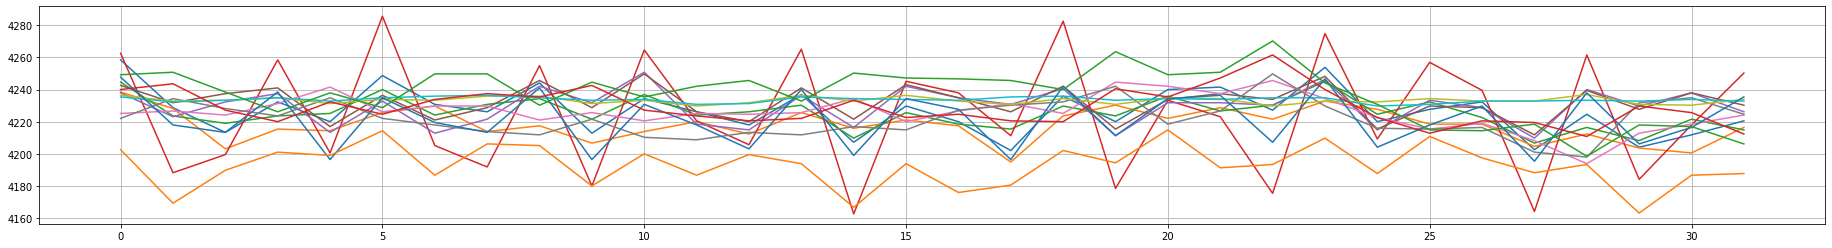

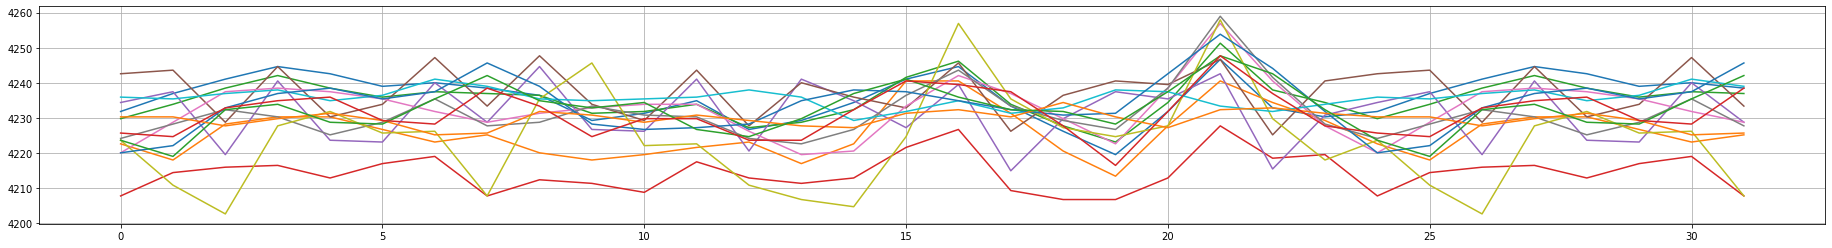

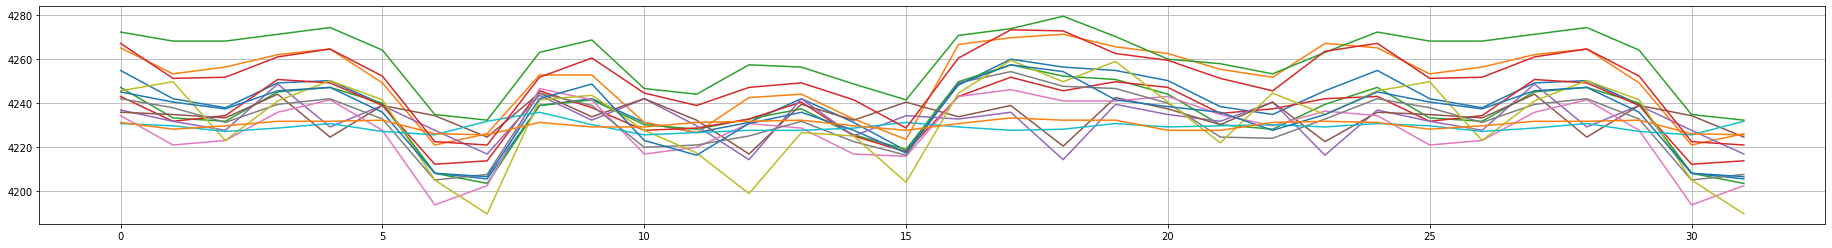

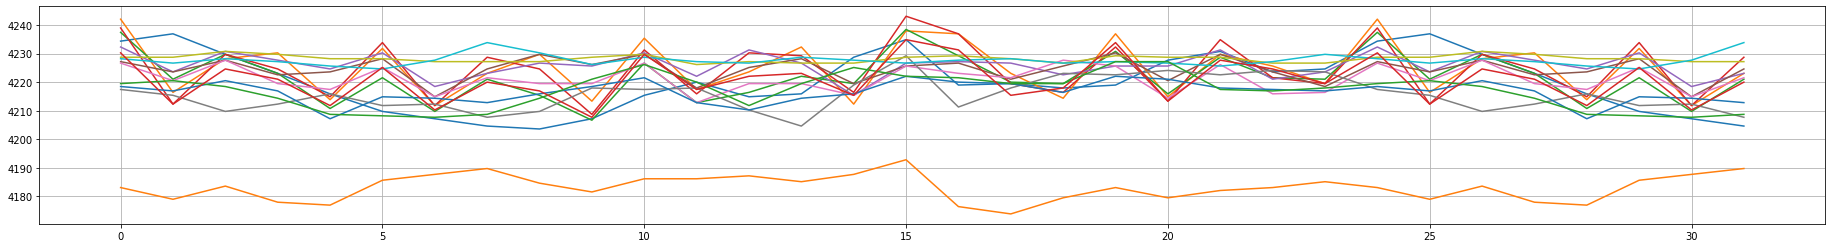

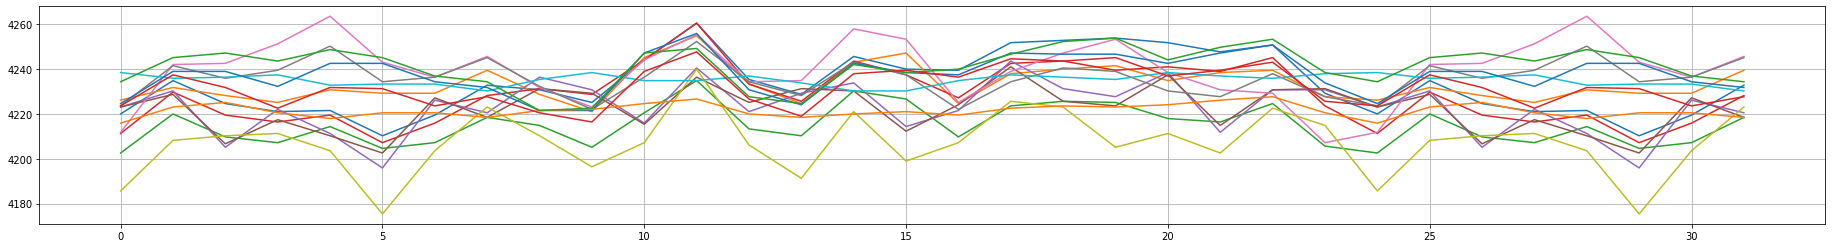

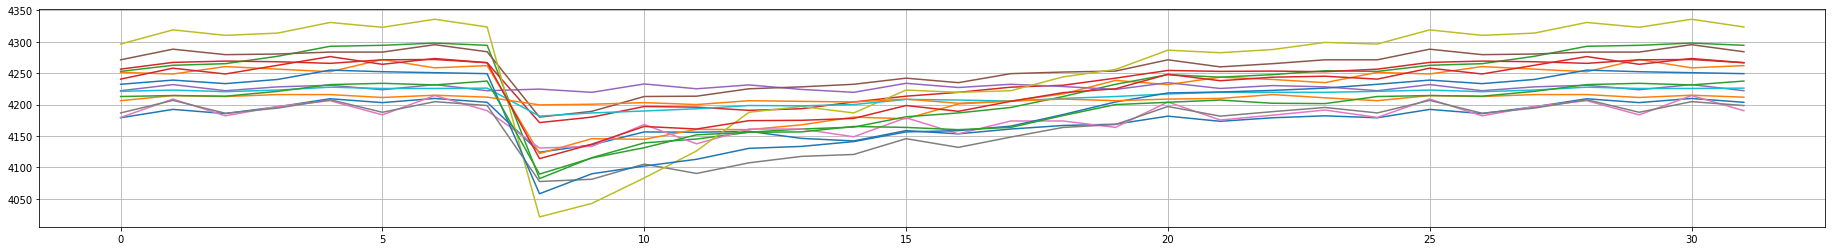

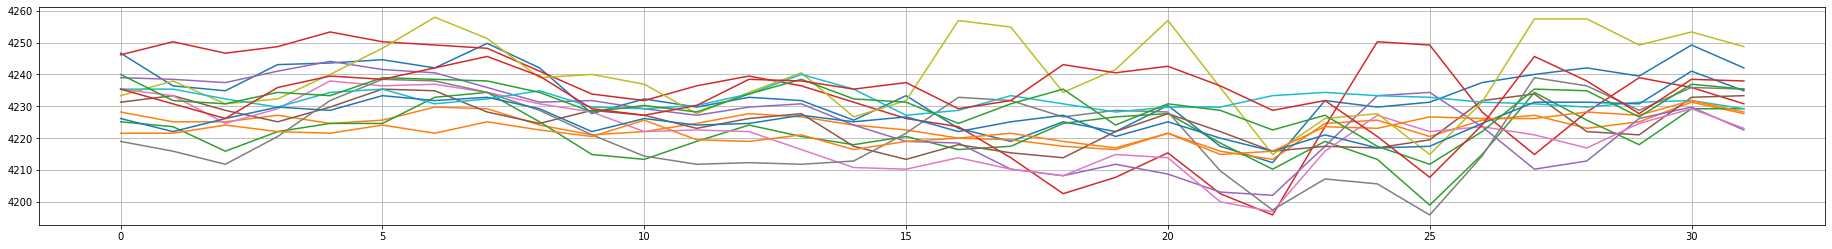

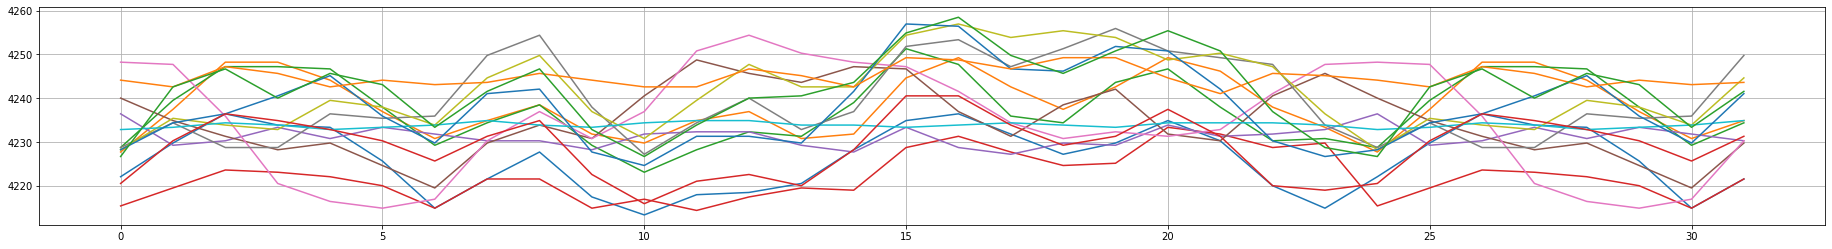

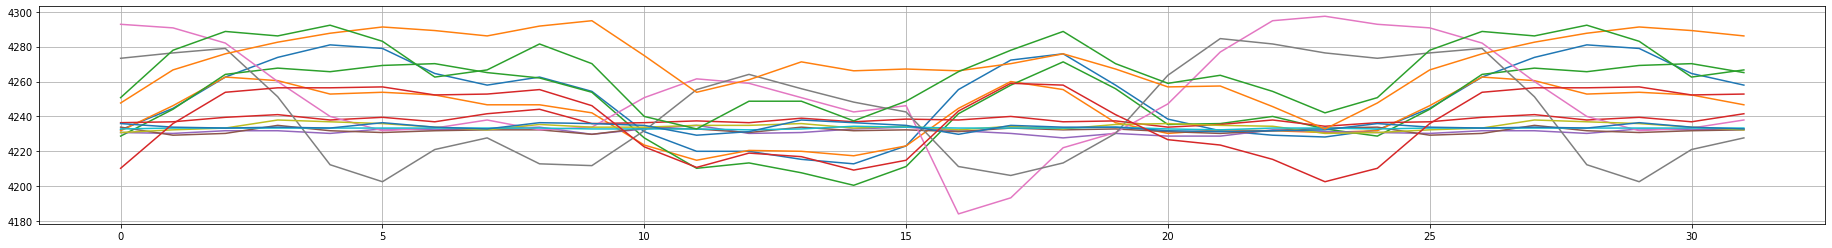

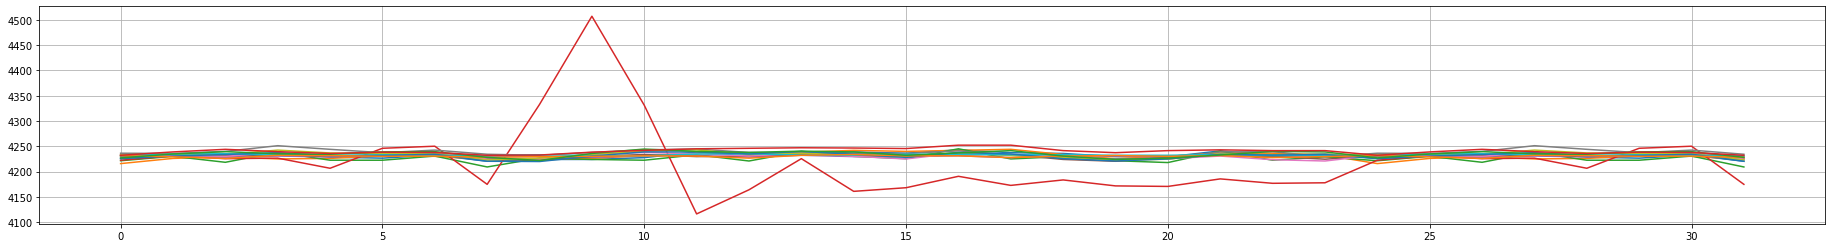

In [13]:
###### Plotting EEG
plt.rcParams["figure.figsize"] = [32,4]
for i in range(10):
    print('=========================================')
    #ica = FastICA(n_components=16, random_state=0)
    plt.plot(X_train[i])
    plt.grid()
    plt.show()
    #plt.plot(ica.fit_transform(X_train[i]))
    #plt.grid()
    #plt.show()

# Channel Selection

## Correlation Coefficient

In [ ]:
######## Covariance Matrix Computation 
####### Pearson Correlation Metric
def pearson_coefficient(c1, c2):
    x = c1
    y = c2
    mx = np.mean(x, axis=0)
    my = np.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = np.sum(xm * ym)
    x_square_sum = np.sum(xm * xm)
    y_square_sum = np.sum(ym * ym)
    r_den = np.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return np.mean(r)

####### Covariance Matrix
def covariance_matrix(eeg_rec):
    
    """
    Function to record covariance_matrix
    
    INPUTS:-
    1) eeg_rec: Numpy Array of EEG Record of dimensions N*C
    
    OUTPUTS:-
    1) cov_mat: Covariance Matrix
    
    """
    
    ###### Defining Variables
    total_channels = 16
    cov_mat = np.zeros((total_channels,total_channels))
    
    ###### Iterating over Channels
    for i in range(total_channels):
        for j in range(total_channels):
            cov_mat[i,j] = pearson_coefficient(eeg_rec[:,i],eeg_rec[:,j])
    
    return cov_mat

In [ ]:
####### Iterating over Dataset
###### Defining Essentials
X_corr = []

###### Iterating over Dataset
for X_rec in X_train:
    X_corr.append(covariance_matrix(X_rec))
    
###### Summing Over Channels
X_corr = np.array(X_corr) # Array Formation
X_corr = np.sum(X_corr,axis=0)/X_corr.shape[0] # Averaging over the examples
print(X_corr)

In [ ]:
###### Function to Plot Confusion Matrix
plt.rcParams["figure.figsize"] = [12,16]
import itertools
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap='magma'):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] < thresh else "black")

    plt.tight_layout()
    #plt.ylabel('True label')
    #plt.xlabel('Predicted label')
    plt.show()

###### Plotting Covariance Matix
cm_plot_labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16']
plot_confusion_matrix(cm=np.round(X_corr,3),classes=cm_plot_labels,normalize=False,title='Cross Correlation Matrix')

In [ ]:
####### Determining Average Correlation
Corr_val = (np.mean(X_corr,axis=0))
print(Corr_val)

###### Determining Order of Relevance
top_channels = []
total_channels = 16
for i in range(total_channels):
    if(Corr_val[i] <= 0.50):
        top_channels.append(i)
print(np.array(top_channels)+1)
print(len(top_channels))

In [ ]:
######## Channel Selection
X_train = np.take(X_train,axis=-1,indices=top_channels)
X_dev = np.take(X_dev,axis=-1,indices=top_channels)

print(X_train.shape)
print(X_dev.shape)

# Model Making

## Multi Frequency Temporal Convolutions

In [14]:
####### Sequential Multi-Temporal Aggregation Module (Seq-MTA)

class MFTempConv(tf.keras.layers.Layer):

    """ Seq_MTA module for capturing long-term dependies in sequential structure """

    def __init__(self,T,C):

        ##### Defining Essentials
        super().__init__()
        self.T = T # Temporal-steps in the input sequence
        self.C = C # Number of channels in the input
        self.split_factor = self.C//4 # Number of channels at output of a convolution

        ##### Defining Layers
        self.conv1 = tf.keras.layers.Conv1D(filters=self.split_factor,kernel_size=15,padding='same',
                        activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        #self.ln1 = tf.keras.layers.LayerNormalization()

        self.conv2 = tf.keras.layers.Conv1D(filters=self.split_factor,kernel_size=5,padding='same',
                        activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        #self.ln2 = tf.keras.layers.LayerNormalization()

        self.conv3 = tf.keras.layers.Conv1D(filters=self.split_factor,kernel_size=3,padding='same',
                        activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        #self.ln3 = tf.keras.layers.LayerNormalization()
        
        self.conv4 = tf.keras.layers.Conv1D(filters=self.split_factor,kernel_size=1,padding='same',
                        activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        #self.ln4 = tf.keras.layers.LayerNormalization()

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'T':self.T,
            'C':self.C,
            'split_factor':self.split_factor
        })
        return config 


    def call(self,X):

        """
        Implementation of MFTempConv Module

        INPUTS:-
        1) X : Input Tensor of Shape [N,T,C] (Implementation involves 'Channel Last' Strategy)

        OUTPUTS:-
        1) X_o : Tensor of shape [N,T,C]

        """
        ##### Performing Split-Across the Channels
        X_i1 = X[:,:,:1*self.split_factor] # 1st Split
        X_i2 = X[:,:,1*self.split_factor:2*self.split_factor] # 2nd Split
        X_i3 = X[:,:,2*self.split_factor:3*self.split_factor] # 3rd Split
        X_i4 = X[:,:,3*self.split_factor:] # 4th Split

        ##### Temporal Aggregations

        #### 1st Block
        X_o1 = self.conv1(X_i1)
        #X_o1 = self.ln1(X_o1)
        #X_o1 = tf.keras.layers.ReLU()(X_o1) # Output of 1st Block

        #### 2nd Block
        X_o2 = self.conv2(X_i2) 
        #X_o2 = self.ln2(X_o2)
        #X_o2 = tf.keras.layers.ReLU()(X_o2) # Output of 2nd Block

        #### 3rd Block
        X_o3 = self.conv3(X_i3) 
        #X_o3 = self.ln3(X_o3)
        #X_o3 = tf.keras.layers.ReLU()(X_o3) # Output of 3rd Block

        #### 4th Block
        X_o4 = self.conv4(X_i4) 
        #X_o4 = self.ln4(X_o4)
        #X_o4 = tf.keras.layers.ReLU()(X_o4) # Output of 3rd Block

        #### Final Concatenation
        X_o = tf.keras.layers.Concatenate(axis=-1)([X_o1,X_o2,X_o3,X_o4]) # Final Concatenation
        
        return X_o

## Neural Activity Excitation (NAE) Module

In [ ]:
####### Neural Activity Excitation Module (NAE-Module)

class NAE_Module(tf.keras.layers.Layer):

    """
    NAE Module highlights the Class-agnostic activity present 
    within EEG-Signal at local-scales.

    """

    def __init__(self,T,C,k_local,k_global,beta=1,gamma=1):

        ##### Defining Essentials
        super().__init__()
        self.T = T # Number of Input Temporal Steps
        self.C = C # Number of Input Channels
        self.k_local = k_local # Kernel Size of Local Convolution
        self.k_global = k_global # Kernel Size of Global Convolution
        self.beta = beta # Weighting Factor of Local-Global Convolution Output
        self.gamma = gamma # Weighting Factor of Residual Design

        ##### Defining Layers
        self.conv_local = tf.keras.layers.Conv1D(filters=self.C, kernel_size=self.k_local,
                                                        padding='same', activation='relu',
                                                        kernel_regularizer=tf.keras.regularizers.l2(1e-5)) 
        self.avg_pool = tf.keras.layers.AveragePooling1D(pool_size=4, strides=4)
        self.conv_global = tf.keras.layers.Conv1D(filters=1, kernel_size=self.k_global,
                                                        padding='same', activation='relu',
                                                        kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.conv_up = tf.keras.layers.Conv1DTranspose(filters=1,kernel_size=4,strides=4,activation='sigmoid')
        self.conv_joint = tf.keras.layers.Conv1D(filters=self.C, kernel_size=15,
                                                        padding='same', activation='relu',
                                                        kernel_regularizer=tf.keras.regularizers.l2(1e-5))

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'T': self.T,
            'C': self.C,
            'k_local': self.k_local,
            'k_global': self.k_global,
            'beta': self.beta,
            'gamma': self.gamma
        })
        return config

    def call(self,X_in):
       
        """
          INPUTS : 1) X_in - Input Tensor of shape (batch_size,T,C)
          OUTPUTS : 1) X_op - Output Tensor of shape (batch_size,T,C)
        """

        ##### Local Feature Learning
        #X_local = self.conv_local(X_in)

        ##### Global Feature Learning
        X_in_compressed = tf.math.reduce_sum(X_in,axis=-1) # Sum-Across Axis Dimensions
        X_in_compressed = tf.keras.layers.Reshape((1500,1))(X_in_compressed) # Reshaping the Compressed Features
        X_compressed = self.avg_pool(X_in_compressed) # Average Pooling
        X_global = self.conv_global(X_compressed) # Global Feature Extraction
        X_global = self.conv_up(X_global) # Upsampling Globally Extracted Features
        
        ##### Neural Activity Detection
        #X_nae = tf.math.multiply(X_local,X_global) # NAE Detection
        #X_op = self.conv_joint(self.beta*X_nae+self.gamma*X_in) # Joint Convolution

        return X_op

## Channel Attention Module

In [ ]:
##### CAM Module(AG-PAD)

class CAM_Module(tf.keras.layers.Layer):
    
    "Custom Layer for Computing Channel Attention,inherited from keras.layers base class"
    
    def __init__(self,num_features,beta):
        
        ##### Defining Instatiations
        super().__init__()
        self.num_features = num_features # Number of channels in the input 
        self.beta = beta # Weighting factor for Attention
                 
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_features': self.num_features,
            'beta' : self.beta
        })
        return config       
    
    def call(self,X):
       
        """
          INPUTS : 1) X - Input Tensor of shape (batch_size,H,W,num_features)
          OUTPUTS : 1) X - Output Tensor of shape (batch_size,H,W,num_features)
        """
        
        ##### Dimension Extraction
        b_s = (X.shape)[0] 
        T = (X.shape)[1]
        C_val = self.num_features
        
        ##### Channel Attention Computation
        #A1 = tf.keras.layers.Reshape((N,C_val))(X)
        #A2 = tf.keras.layers.Reshape((N,C_val))(X)
        X2 = tf.keras.layers.Permute((2,1))(X)
        
        Q = tf.linalg.matmul(X2,X)
        Q = tf.keras.layers.Softmax(axis=2)(Q)
        Q = tf.linalg.matmul(X,Q)
        #Q = tf.keras.layers.Reshape((H,W,C_val))(Q)
        
        M = tf.keras.layers.Add()([self.beta*Q,X])
        return M

## Arc-Loss

In [ ]:
class ArcFace(tf.keras.layers.Layer):
    
    def __init__(self, n_classes, s, m,regularizer):
        super().__init__()
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer = tf.keras.regularizers.get(regularizer)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'regularizer': self.regularizer
        })
        return config

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True
                                )

    def call(self, inputs):
        x, y = inputs
        c = tf.keras.backend.shape(x)[-1]
        # normalize feature
        x = tf.nn.l2_normalize(x, axis=1)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0)
        # dot product
        logits = x @ W
        # add margin
        # clip logits to prevent zero division when backward
        theta = tf.acos(tf.keras.backend.clip(logits, -1.0 + tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon()))
        target_logits = tf.cos(theta + self.m)
        # sin = tf.sqrt(1 - logits**2)
        # cos_m = tf.cos(logits)
        # sin_m = tf.sin(logits)
        # target_logits = logits * cos_m - sin * sin_m
        #
        logits = logits * (1 - y) + target_logits * y
        # feature re-scale
        logits *= self.s
        out = tf.nn.softmax(logits)    
        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)

# Model Training

In [20]:
###### Defining Architecture

#with tpu_strategy.scope():

#### Defining Hyperparameters
#num_layers = 2
#d_model = 128
#num_heads = 8
#dff = 256
max_seq_len = 32 #X_train.shape[1]
#pe_input = 186
#rate = 0.3
num_features = 14

###### Defining Layers
Input_layer = tf.keras.layers.Input(shape=(max_seq_len,num_features))
#Input_Labels = tf.keras.layers.Input(shape=(26,))

##### Convolutional Filters

### Layer-1
conv1 = tf.keras.layers.Conv1D(32,3,padding='same',activation='relu')
conv11 = tf.keras.layers.Conv1D(32,3,padding='same',activation='relu') #MFTempConv(32,128)
conv12 = tf.keras.layers.Conv1D(32,3,padding='same',activation='relu') #MFTempConv(32,128) 
conv13 = tf.keras.layers.Conv1D(32,3,padding='same',activation='relu') #MFTempConv(32,128)

### Layer-2
conv2 = tf.keras.layers.Conv1D(64,3,padding='same',activation='relu')
conv21 = tf.keras.layers.Conv1D(64,3,padding='same',activation='relu')
conv22 = tf.keras.layers.Conv1D(64,3,padding='same',activation='relu')
conv23 = tf.keras.layers.Conv1D(64,3,padding='same',activation='relu')

### Layer-3
conv3 = tf.keras.layers.Conv1D(128,3,padding='same',activation='relu')
conv31 = tf.keras.layers.Conv1D(128,3,padding='same',activation='relu')
conv32 = tf.keras.layers.Conv1D(128,3,padding='same',activation='relu')
conv33 = tf.keras.layers.Conv1D(128,3,padding='same',activation='relu')

#### Channel Attention Module
#cam_module = CAM_Module(16,1)

##### Transfromer Layer
#transformer = Transformer(num_layers,d_model,num_heads,dff,pe_input,rate)

##### Output Layer
gap_layer = tf.keras.layers.GlobalAveragePooling1D()

##### ArcFace Loss
#arc_logit_layer = ArcFace(26,30.0,0.3,tf.keras.regularizers.l2(1e-4))

###### Defining Architecture
##### Input Layer
Inputs = Input_layer
#Input_Labels = tf.keras.layers.Input(shape=(26,))

##### CAM Module
#cam_op = cam_module(Inputs)

##### Network
#### Layer-1
conv1_up = conv1(Inputs)
conv_11 = conv11(conv1_up) 
conv_12 = conv12(conv_11)
conv_13 = conv13(conv_12)
conv_13 = tf.keras.layers.Add()([conv_13,conv_11])
#lstm_1 = tf.keras.layers.LSTM(units=128)(conv_13)

#### Layer-2
conv2_up = conv2(conv_13)
conv_21 = conv21(conv2_up)
conv_22 = conv22(conv_21)
conv_23 = conv23(conv_22)
conv_23 = tf.keras.layers.Add()([conv_23,conv_21])

#### Layer-3
conv3_up = conv3(conv_23)
conv_31 = conv31(conv3_up)
conv_32 = conv32(conv_31)
conv_33 = conv33(conv_32)
conv_33 = tf.keras.layers.Add()([conv_33,conv_31])

##### Transformer
#embeddings =  transformer(inp=conv_33,enc_padding_mask=None)

##### CAM Module
#cam_op = cam_module(conv_33)
#cam_op = tf.keras.layers.Add()([cam_op,embeddings])

##### Output Layers
#### Initial Layers
gap_op = gap_layer(conv_33) #(N,1500,32)
dense1 = tf.keras.layers.Dense(256,activation='relu')(gap_op)
dropout1 = tf.keras.layers.Dropout(0.3)(dense1)

#### Softmax Output Layer
dense2 = tf.keras.layers.Dense(256,activation='relu')(dropout1)
dense3 = tf.keras.layers.Dense(10,activation='softmax')(dense2)

#### ArcFace Output Layer
#dense2 = tf.keras.layers.Dense(256,kernel_initializer='he_normal',
#            kernel_regularizer=tf.keras.regularizers.l2(1e-4))(dropout1)
#dense3 = arc_logit_layer(([dense2,Input_Labels]))

#### Triplet Loss
#dense2 = tf.keras.layers.Dense(units=256,activation='linear',kernel_initializer='he_normal')(dropout1)
#dense3 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense2)

##### Compiling Architecture            
model = tf.keras.models.Model(inputs=Input_layer,outputs=dense3)
#model.load_weights('./EBT_Thoughtviz_Characters.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()      
tf.keras.utils.plot_model(model)

###### Model Training 

##### Model Checkpointing
filepath = './EBT_Thoughtviz_Characters.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_accuracy',save_best_only=True,mode='max',save_weights_only=True)
#checkpoint_triplet = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss',save_best_only=True,mode='min')

##### Softmax Training 
###### Training the Model
history = model.fit(X_train,y_train,epochs=1000,batch_size=512,
            validation_data=(X_dev,y_dev),validation_batch_size=512,
           callbacks=checkpoint)

###### Plotting Metrics  
##### Accuracy and Loss Plots 

#### Accuracy
plt.rcParams["figure.figsize"] = [12,6]
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')  
plt.legend(['Train', 'Testing'], loc='best')
plt.grid(b='True',which='both')
plt.show()

### Loss     
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])
plt.title('Model Loss')  
plt.ylabel('Loss')         
plt.xlabel('epoch')
plt.legend(['Train', 'Testing'], loc='best')
plt.grid(b='True',which='both')
plt.show() 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 14)]     0                                            
__________________________________________________________________________________________________
conv1d_96 (Conv1D)              (None, 32, 32)       1376        input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_97 (Conv1D)              (None, 32, 32)       3104        conv1d_96[0][0]                  
__________________________________________________________________________________________________
conv1d_98 (Conv1D)              (None, 32, 32)       3104        conv1d_97[0][0]                  
____________________________________________________________________________________________

KeyboardInterrupt: 

# Model Evaluation

## Softmax Accuracy Evaluation

In [23]:
###### Defining Architecture

#with tpu_strategy.scope():

#### Defining Hyperparameters
#num_layers = 2
#d_model = 128
#num_heads = 8
#dff = 256
max_seq_len = 32 #X_train.shape[1]
#pe_input = 186
#rate = 0.3
num_features = 14

###### Defining Layers
Input_layer = tf.keras.layers.Input(shape=(max_seq_len,num_features))
#Input_Labels = tf.keras.layers.Input(shape=(26,))

##### Convolutional Filters

### Layer-1
conv1 = tf.keras.layers.Conv1D(32,3,padding='same',activation='relu')
conv11 = tf.keras.layers.Conv1D(32,3,padding='same',activation='relu') #MFTempConv(32,128)
conv12 = tf.keras.layers.Conv1D(32,3,padding='same',activation='relu') #MFTempConv(32,128) 
conv13 = tf.keras.layers.Conv1D(32,3,padding='same',activation='relu') #MFTempConv(32,128)

### Layer-2
conv2 = tf.keras.layers.Conv1D(64,3,padding='same',activation='relu')
conv21 = tf.keras.layers.Conv1D(64,3,padding='same',activation='relu')
conv22 = tf.keras.layers.Conv1D(64,3,padding='same',activation='relu')
conv23 = tf.keras.layers.Conv1D(64,3,padding='same',activation='relu')

### Layer-3
conv3 = tf.keras.layers.Conv1D(128,3,padding='same',activation='relu')
conv31 = tf.keras.layers.Conv1D(128,3,padding='same',activation='relu')
conv32 = tf.keras.layers.Conv1D(128,3,padding='same',activation='relu')
conv33 = tf.keras.layers.Conv1D(128,3,padding='same',activation='relu')

#### Channel Attention Module
#cam_module = CAM_Module(16,1)

##### Transfromer Layer
#transformer = Transformer(num_layers,d_model,num_heads,dff,pe_input,rate)

##### Output Layer
gap_layer = tf.keras.layers.GlobalAveragePooling1D()

##### ArcFace Loss
#arc_logit_layer = ArcFace(26,30.0,0.3,tf.keras.regularizers.l2(1e-4))

###### Defining Architecture
##### Input Layer
Inputs = Input_layer
#Input_Labels = tf.keras.layers.Input(shape=(26,))

##### CAM Module
#cam_op = cam_module(Inputs)

##### Network
#### Layer-1
conv1_up = conv1(Inputs)
conv_11 = conv11(conv1_up) 
conv_12 = conv12(conv_11)
conv_13 = conv13(conv_12)
conv_13 = tf.keras.layers.Add()([conv_13,conv_11])
#lstm_1 = tf.keras.layers.LSTM(units=128)(conv_13)

#### Layer-2
conv2_up = conv2(conv_13)
conv_21 = conv21(conv2_up)
conv_22 = conv22(conv_21)
conv_23 = conv23(conv_22)
conv_23 = tf.keras.layers.Add()([conv_23,conv_21])

#### Layer-3
conv3_up = conv3(conv_23)
conv_31 = conv31(conv3_up)
conv_32 = conv32(conv_31)
conv_33 = conv33(conv_32)
conv_33 = tf.keras.layers.Add()([conv_33,conv_31])

##### Transformer
#embeddings =  transformer(inp=conv_33,enc_padding_mask=None)

##### CAM Module
#cam_op = cam_module(conv_33)
#cam_op = tf.keras.layers.Add()([cam_op,embeddings])

##### Output Layers
#### Initial Layers
gap_op = gap_layer(conv_33) #(N,1500,32)
dense1 = tf.keras.layers.Dense(256,activation='relu')(gap_op)
dropout1 = tf.keras.layers.Dropout(0.3)(dense1)

#### Softmax Output Layer
dense2 = tf.keras.layers.Dense(256,activation='relu')(dropout1)
dense3 = tf.keras.layers.Dense(10,activation='softmax')(dense2)

#### ArcFace Output Layer
#dense2 = tf.keras.layers.Dense(256,kernel_initializer='he_normal',
#            kernel_regularizer=tf.keras.regularizers.l2(1e-4))(dropout1)
#dense3 = arc_logit_layer(([dense2,Input_Labels]))

#### Triplet Loss
#dense2 = tf.keras.layers.Dense(units=256,activation='linear',kernel_initializer='he_normal')(dropout1)
#dense3 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense2)

##### Compiling Architecture            
model = tf.keras.models.Model(inputs=Input_layer,outputs=dense3)
model.load_weights('./EBT_Thoughtviz_Characters.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

###### Evaluating Model
[val_loss,val_accuracy] = model.evaluate(X_dev,y_dev)
print('Model Accuracy is '+str(val_accuracy*100)+' %')

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


177/177 [==============================] - 1s 3ms/step - loss: 3.0553 - accuracy: 0.7044
Model Accuracy is 70.43601274490356 %


## Confusion Matrix

//////////////////////////////////
[[388   8  18   5  15  19  40  19  20  31]
 [ 23 394   6   9  19  20  23  25  20  36]
 [ 16  22 395  13  14  34  13   4  14  34]
 [ 16  17  20 393  11  26  35  34   8   7]
 [ 30  17  35   9 389  18  22  33   7  19]
 [ 16  16   8   8  18 456   5   7  12  21]
 [ 16   3  10  13  28  18 391  42  24  22]
 [ 38  19   6  19  17  25  19 387  10  15]
 [ 24   7  24   9  24  20  13  41 360  33]
 [ 24  13  16   4   9  17  13  31   7 421]]
//////////////////////////////////
Confusion matrix, without normalization


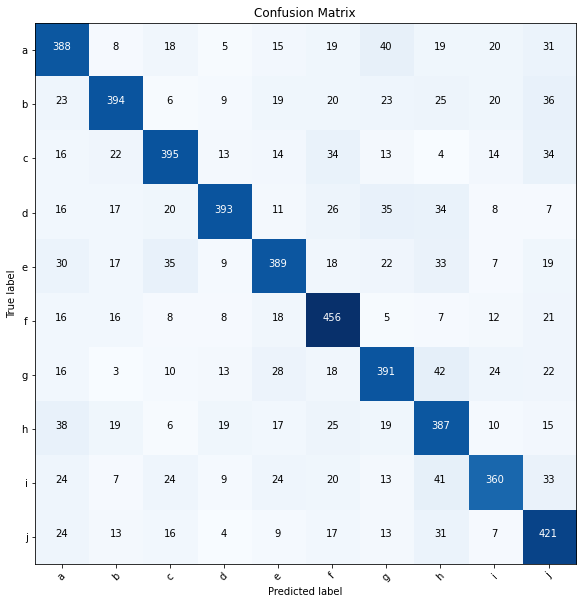

In [25]:
###### Function to Plot Confusion Matrix
plt.rcParams["figure.figsize"] = [8,12]
import itertools
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
###### Confusion Matrix Computation
y_preds = model.predict(X_dev)
cm = confusion_matrix(y_dev,np.argmax(y_preds,axis=1))
print('//////////////////////////////////')
print(cm)
print('//////////////////////////////////')

###### Plotting Confusion Matix
cm_plot_labels = ['a','b','c','d','e','f','g','h','i','j']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,normalize=False,title='Confusion Matrix')
#plot_confusion_matrix(cm=cm,classes=cm_plot_labels,normalize=True,title='Confusion Matrix')

## Arc-Face Evaluation

In [ ]:
##### Nearest Neighbor Classification
from sklearn.neighbors import KNeighborsClassifier

##### Model Creation
predictive_model = tf.keras.models.Model(inputs=model.input,outputs=model.layers[-3].output)
predictive_model.compile(tf.keras.optimizers.Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

Input_Layer = tf.keras.layers.Input((max_seq_len,16))
y_in = tf.keras.layers.Input((26,))
op_1 = predictive_model([Input_Layer,y_in])
final_norm_op = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(op_1)  
testing_model = tf.keras.models.Model(inputs=[Input_Layer,y_in],outputs=final_norm_op)
testing_model.compile(tf.keras.optimizers.Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

#### Triplet Loss
Test_Embeddings = testing_model.predict((X_dev,y_dev_onehot))
Train_Embeddings = testing_model.predict((X_train,y_train_onehot))

col_mean = np.nanmean(Test_Embeddings, axis=0)
inds = np.where(np.isnan(Test_Embeddings))
#print(inds)
Test_Embeddings[inds] = np.take(col_mean, inds[1])

col_mean = np.nanmean(Train_Embeddings, axis=0)
inds = np.where(np.isnan(Train_Embeddings))
#print(inds)
Train_Embeddings[inds] = np.take(col_mean, inds[1])

Test_Accuracy_With_Train = []
Test_Accuracy_With_Test = []
acc_max = 0

for k in range(1,5):
  
    knn = KNeighborsClassifier(n_neighbors=k,metric='euclidean')
    knn.fit(Train_Embeddings,y_train)
    Test_Accuracy_With_Train.append(knn.score(Test_Embeddings,y_dev))

    if(k == 1):
        y_preds_1 = knn.predict(Test_Embeddings)

    if(acc_max < Test_Accuracy_With_Train[k-1]):
        acc_max = Test_Accuracy_With_Train[k-1]
        y_preds_max = knn.predict(Test_Embeddings)

    knn.fit(Test_Embeddings,y_dev)
    Test_Accuracy_With_Test.append(knn.score(Test_Embeddings,y_dev))

print('--------------------------------')
print(np.max(Test_Accuracy_With_Train))
print(np.max(Test_Accuracy_With_Test))
print('--------------------------------')
print(np.mean(Test_Accuracy_With_Train))
print(np.mean(Test_Accuracy_With_Test))
print('--------------------------------')
print((Test_Accuracy_With_Train)[0])
print((Test_Accuracy_With_Test)[0])
print('--------------------------------')

plt.plot(np.arange(1,5),np.array(Test_Accuracy_With_Train),label='Test_Accuracy_With_Train')
plt.plot(np.arange(1,5),np.array(Test_Accuracy_With_Test),label='Test_Accuracy_With_Test')
plt.title('Testing Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show() 

In [ ]:
###### t-SNE Plotting
import seaborn as sns
from sklearn.manifold import TSNE

#### Computing and Saving Output 
#np.savez_compressed('./Embeddings/RDCML_Softmax_Ablation.npz',Test_Embeddings)

#### t-SNE Plots
### t-SNE Embeddings
tsne_X_dev = TSNE(n_components=2,perplexity=30,learning_rate=10,n_iter=5000,n_iter_without_progress=50).fit_transform(Test_Embeddings) # t-SNE Plots 

### Plotting
plt.rcParams["figure.figsize"] = [12,8]
for idx,color_index in zip(list(np.arange(26)),sns.color_palette()):
    plt.scatter(tsne_X_dev[y_dev == idx, 0],tsne_X_dev[y_dev == idx, 1],s=40,color=color_index,edgecolors='k',marker='h')
plt.legend(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'],loc='best')
plt.grid(b='True',which='both')
plt.savefig('./MHM_Stress_WESAD_DML_Ablation.png')
plt.show()